##挂载云盘

In [41]:
#挂载云盘 
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#进入项目目录
!ls
import os
os.chdir('/content/drive/My Drive/Project/ARIMA残差图')
!ls

ARIMA.ipynb  data1204.xlsx  SARIMA.ipynb
ARIMA.ipynb  data1204.xlsx  SARIMA.ipynb


##读取数据

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
%matplotlib inline
plt.style.use('fivethirtyeight')

        Month           HTN  ...        BP组合模型        线性组合模型
67 2018-02-01  1.335021e+09  ...  1.306201e+09  1.286490e+09
68 2018-03-01  1.931297e+09  ...  1.811384e+09  1.814234e+09
69 2018-04-01  1.777090e+09  ...  1.719649e+09  1.692118e+09
70 2018-05-01  1.711097e+09  ...  1.729404e+09  1.723852e+09
71 2018-06-01  1.739383e+09  ...  1.746347e+09  1.742575e+09

[5 rows x 10 columns]


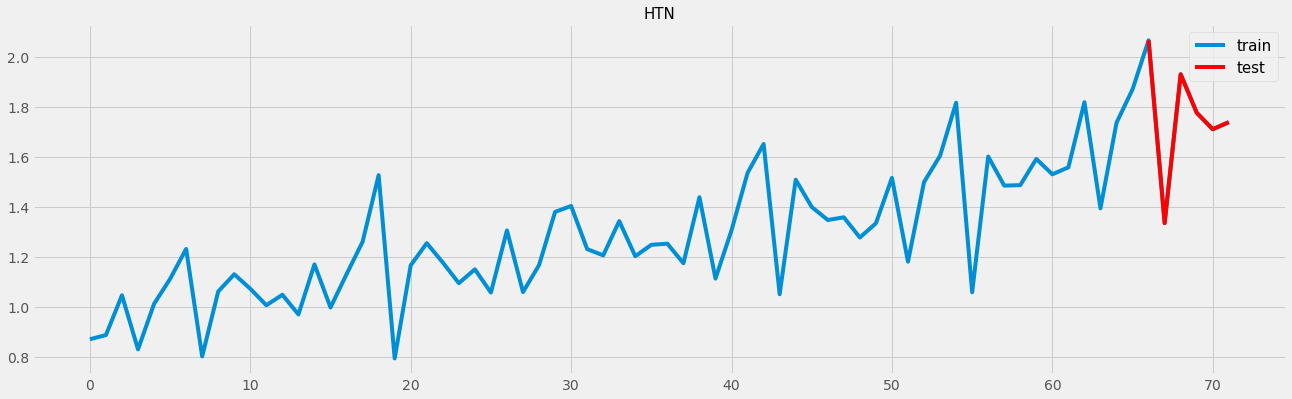

In [43]:
#读取数据 
data=pd.read_excel('data1204.xlsx') 
data=data.iloc[:,:]
choose='HTN' #选取这一列
print(data.tail())
#展示一下看看
data=data[choose]
data=data/1000000000#进行伪归一化
#构建训练集测试集
cut=6#取最后cut天为测试集
y=data[:-cut]
true=data[-cut:]
plt.figure(figsize=(20,6))  #创建图形
plt.plot(data)
plt.plot(true,color='red')
plt.legend(('train', 'test'),fontsize='15')
plt.title(choose,fontsize='15') #添加标题
#plt.grid()
plt.show()

##ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -46.43824 | order: (4, 1, 3)


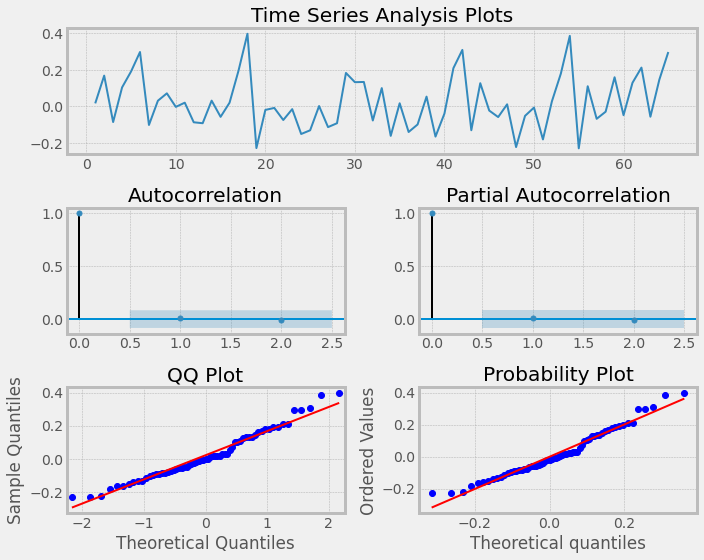

In [44]:
#导入数据
import itertools
import warnings
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
np.random.seed(100)
#用来画残差图 直接调用即可
import statsmodels.tsa.api as smt
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(y, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=2)

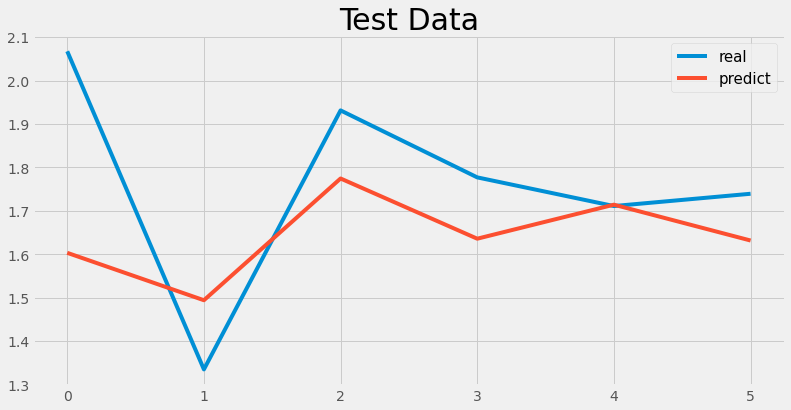

测试集上的MAE/MSE/MAPE/涨跌准确率
0.17199769180778493
0.04946213390836546
10.64016131558395
0.6


In [51]:
#以下函数均为对模型进行检验所用到的  精简代码的作用
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
def output():
    #展示在测试集上的表现 
    draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
    draw.iloc[:,0].plot(figsize=(12,6))
    draw.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
    plt.title("Test Data",fontsize='30') #添加标题
    plt.show()
    #输出结果
    print('测试集上的MAE/MSE/MAPE/涨跌准确率')
    print(mean_absolute_error(y_test_predict, y_test))
    print(mean_squared_error(y_test_predict, y_test) )
    print(mape(y_test_predict,  y_test) )
    print(up_down_accuracy(y_test_predict,y_test))
#展示效果
#预测
y_test_predict, err95, ci95 = best_mdl.forecast(steps=len(true))
y_test=true.values
output()

##残差图

In [76]:
#用来画残差图 直接调用即可
import statsmodels.tsa.api as smt
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

def fun_plot(target, name):
  print('==============================================')
  pred = data[name]
  print(name)
  res = target.values - pred.values
  tsplot(res)



        Month           HTN  ...        BP组合模型        线性组合模型
14 2013-09-01  1.169668e+09  ...  1.193312e+09  1.183287e+09
15 2013-10-01  9.968032e+08  ...  9.531866e+08  9.494551e+08
16 2013-11-01  1.130331e+09  ...  1.111793e+09  1.099272e+09
17 2013-12-01  1.259970e+09  ...  1.220817e+09  1.205967e+09
18 2014-01-01  1.526990e+09  ...  1.327582e+09  1.303193e+09

[5 rows x 10 columns]
ARIMA1
弹性网回归1
SVR1
BP1
holt-winters
LSTM
BP组合模型
线性组合模型


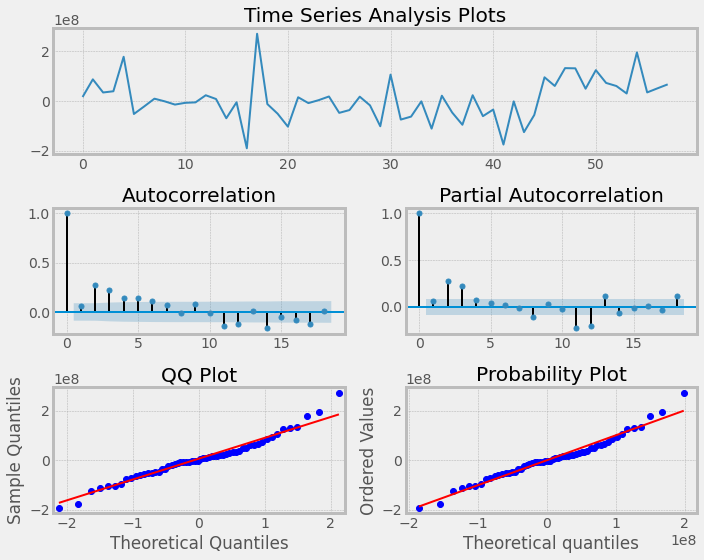

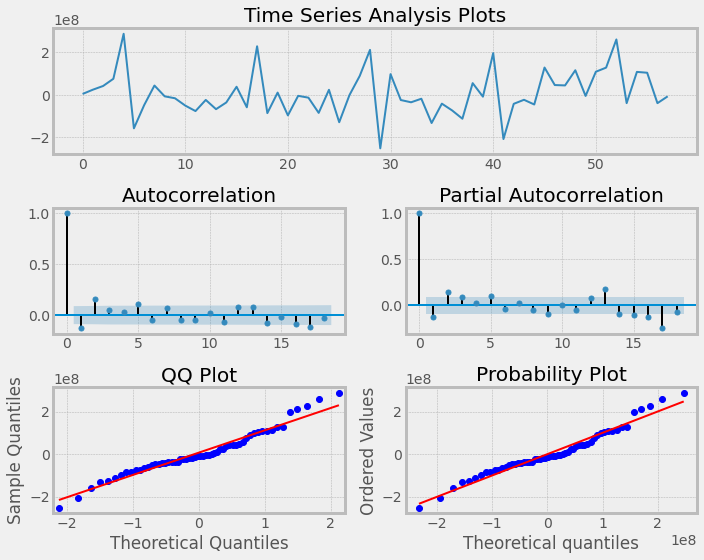

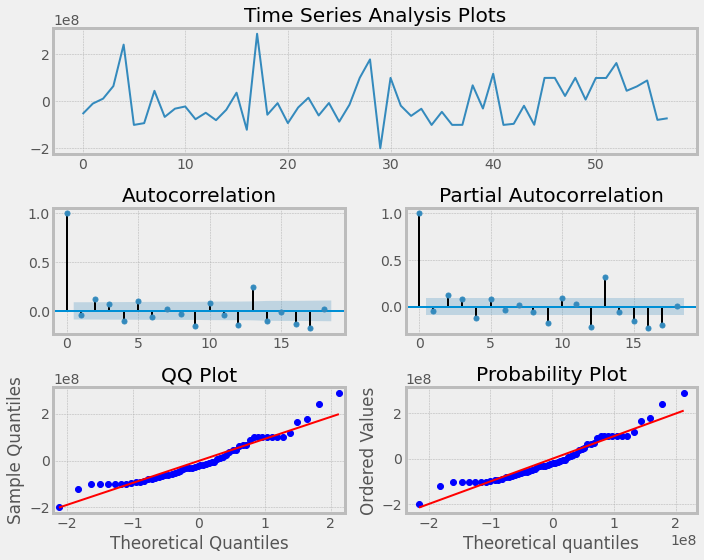

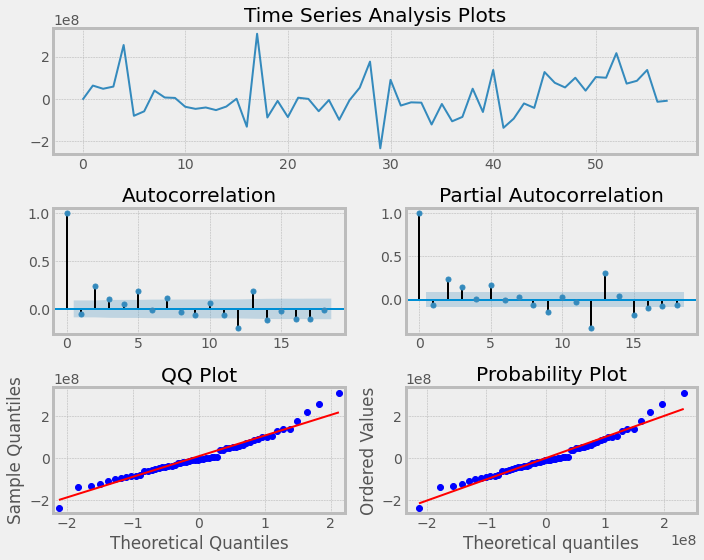

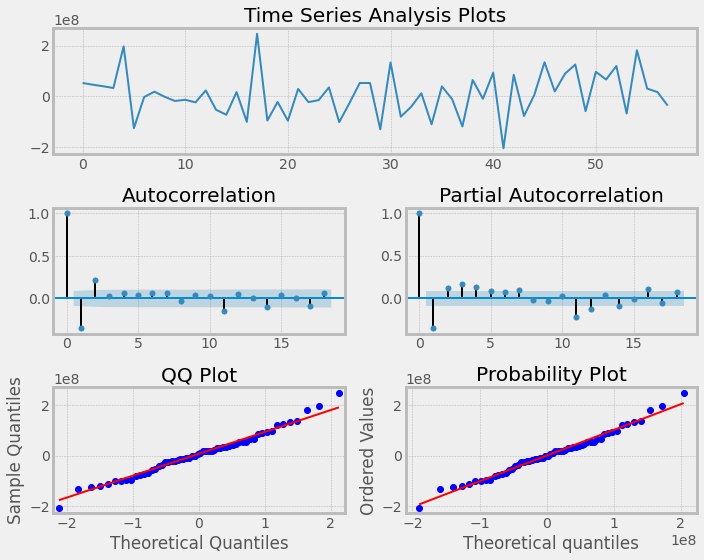

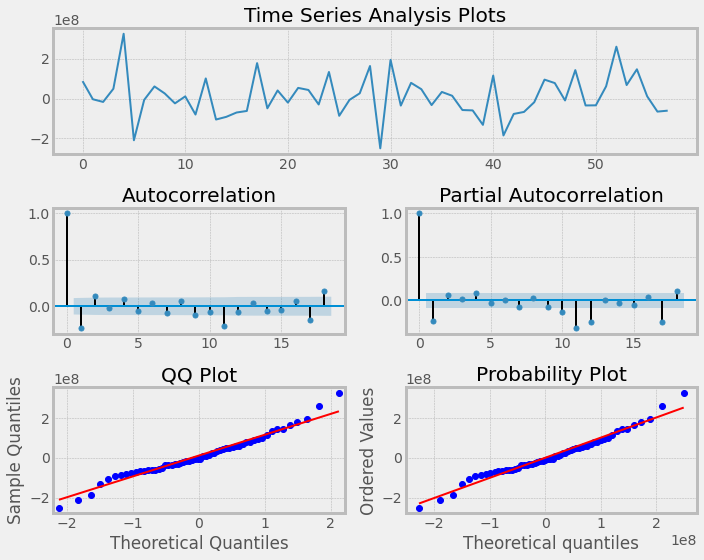

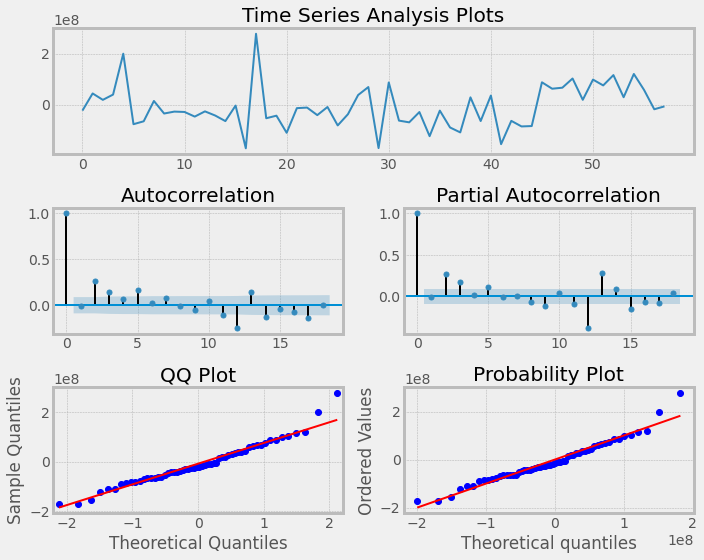

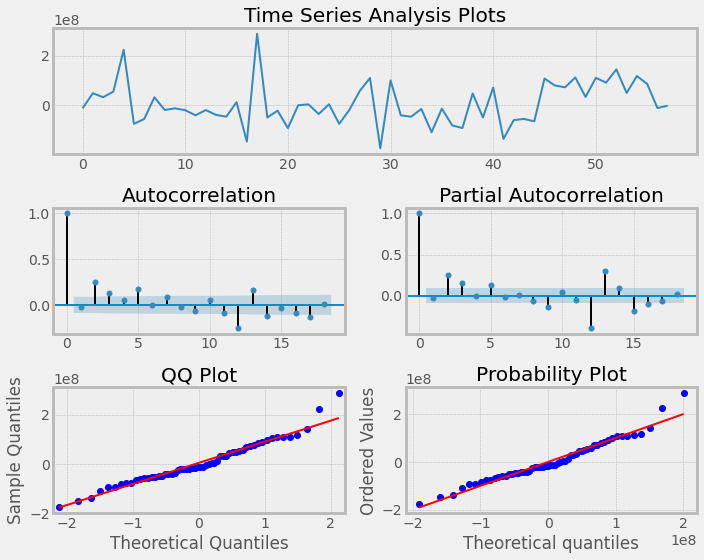

In [77]:
#读取数据 
data=pd.read_excel('data1204.xlsx') 
data = data.iloc[14:]
print(data.head())
target = data['HTN']
for name in data.columns[2:]:
  fun_plot(target, name)